In [1]:
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import datetime

In [2]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [3]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

61306/61306 [==============================] - 0s 1us/step


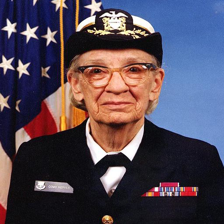

In [4]:
grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
grace_hopper = np.array(grace_hopper)/255.
grace_hopper.shape

(224, 224, 3)

In [10]:
result = classifier.predict(tf.expand_dims(grace_hopper, axis=0))
result.shape

1/1 [==============================] - 0s 28ms/step


(1, 1001)

In [11]:
predicted_class = tf.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

In [12]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 1us/step


Text(0.5, 1.0, 'Prediction: military uniform')

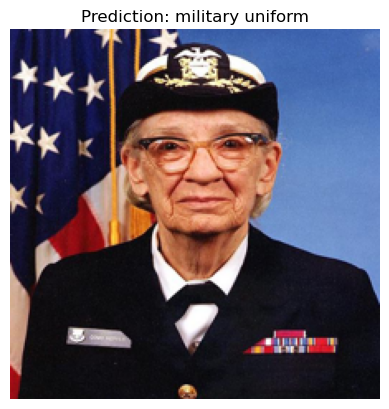

In [15]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plt.title(f'Prediction: {predicted_class_name}')

## Transfer learning adapted to customer dataset

In [17]:
import pathlib
data_file = tf.keras.utils.get_file(
'flower_photos.tgz',
'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
cache_dir='.',
extract=True)

data_root = pathlib.Path(data_file).with_suffix('')

228813984/228813984 [==============================] - 5s 0us/step


In [18]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
str(data_root),
validation_split=0.2,
subset='training',
seed=123,
image_size=(img_height,img_width),
batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
str(data_root),
validation_split=0.2,
subset='validation',
seed=123,
image_size=(img_height,img_width),
batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [19]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [20]:
normalization_layer = tf.keras.layers.Rescaling(1/255.)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x,y: (normalization_layer(x), y))

In [22]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [23]:
result_batch = classifier.predict(train_ds)

92/92 [==============================] - 12s 123ms/step


In [27]:
predicted_class_names = imagenet_labels[tf.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'daisy', 'stinkhorn', ..., 'daisy', 'balloon', 'bee'],
      dtype='<U30')

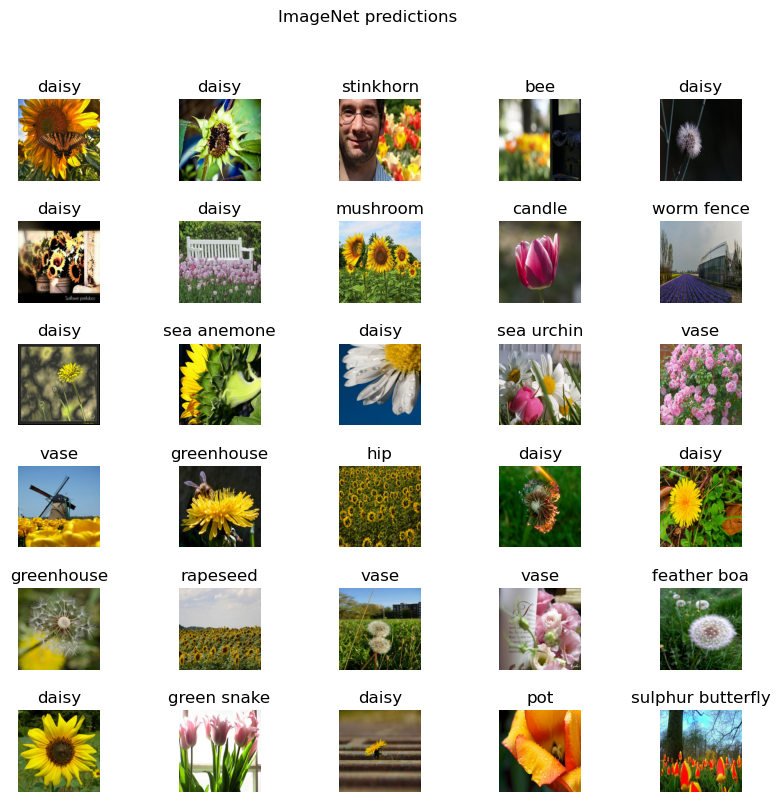

In [28]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5, n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    plt.suptitle('ImageNet predictions')